In [1]:
"""
@author: Maziar Raissi
"""
import sys
sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from pyDOE import lhs
import time
from plotting import newfig, savefig
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

Loss: 4.651525e+01
Loss: 1.787498e+04
Loss: 1.437561e+01
Loss: 2.620550e+00
Loss: 2.342708e-01
Loss: 1.493185e-01
Loss: 1.621220e-02
Loss: 1.615385e-02
Loss: 1.615340e-02
Loss: 1.615183e-02
Loss: 1.614518e-02
Loss: 1.611820e-02
Loss: 1.605781e-02
Loss: 1.589566e-02
Loss: 1.551616e-02
Loss: 1.472208e-02
Loss: 1.347386e-02
Loss: 1.201570e-02
Loss: 1.115405e-02
Loss: 1.111449e-02
Loss: 1.111370e-02
Loss: 1.111329e-02
Loss: 1.111218e-02
Loss: 1.110944e-02
Loss: 1.110174e-02
Loss: 1.108271e-02
Loss: 1.103193e-02
Loss: 1.090014e-02
Loss: 1.053174e-02
Loss: 9.055433e-03
Loss: 3.560640e-02
Loss: 8.012684e-03
Loss: 3.342701e-02
Loss: 7.784124e-03
Loss: 7.667910e-03
Loss: 7.568681e-03
Loss: 7.387316e-03
Loss: 7.359711e-03
Loss: 7.330666e-03
Loss: 7.285658e-03
Loss: 7.275323e-03
Loss: 7.271466e-03
Loss: 7.267037e-03
Loss: 7.251815e-03
Loss: 7.212271e-03
Loss: 7.103520e-03
Loss: 6.818064e-03
Loss: 6.269427e-03
Loss: 4.596271e-03
Loss: 7.645117e-03
Loss: 3.580923e-03
Loss: 2.636813e-03
Loss: 8.4588

RuntimeError: The command
    ['latex', '-interaction=nonstopmode', '"C:/Users/702-user/AppData/Local/Temp/tmpmo5ia480/tmp.ps.tex"']
failed and generated the following output:
This is pdfTeX, Version 3.1415926-2.5-1.40.14 (MiKTeX 2.9)
entering extended mode
(C:/Users/702-user/AppData/Local/Temp/tmpmo5ia480/tmp.ps.tex
LaTeX2e <2014/05/01>
Babel <3.9l> and hyphenation patterns for 68 languages loaded.
("C:\Program Files (x86)\MiKTeX 2.9\tex\latex\base\article.cls"
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
("C:\Program Files (x86)\MiKTeX 2.9\tex\latex\base\size10.clo"))
("C:\Program Files (x86)\MiKTeX 2.9\tex\latex\type1cm\type1cm.sty")
("C:\Program Files (x86)\MiKTeX 2.9\tex\latex\base\textcomp.sty"
("C:\Program Files (x86)\MiKTeX 2.9\tex\latex\base\ts1enc.def"))
======================================================================
latex: Try Again
latex: Data: get host by name failed in tcp_connect()
======================================================================


! LaTeX Error: File `ucs.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               [utf8x]{inputenc}
No pages of output.
Transcript written on tmp.ps.log.


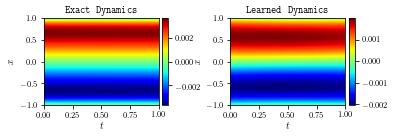

In [5]:


###############################################################################
############################## Helper Functions ###############################
###############################################################################

def initialize_NN(layers):
    weights = []
    biases = []
    num_layers = len(layers) 
    for l in range(0,num_layers-1):
        W = xavier_init(size=[layers[l], layers[l+1]])
        b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)
        biases.append(b)        
    return weights, biases
    
def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]        
    xavier_stddev = np.sqrt(2/(in_dim + out_dim))
    return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=tf.float32), dtype=tf.float32)

def neural_net(X, weights, biases):
    num_layers = len(weights) + 1
    H = X
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.sin(tf.add(tf.matmul(H, W), b))
    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y

###############################################################################
################################ DeepHPM Class ################################
###############################################################################

class DeepHPM:
    def __init__(self, t, x, u,
                       x0, u0, tb, X_f,
                       u_layers, pde_layers,
                       layers,
                       lb_idn, ub_idn,
                       lb_sol, ub_sol):
        
        # Domain Boundary
        self.lb_idn = lb_idn
        self.ub_idn = ub_idn
        
        self.lb_sol = lb_sol
        self.ub_sol = ub_sol
        
        # Init for Identification
        self.idn_init(t, x, u, u_layers, pde_layers)
        
        # Init for Solution
        self.sol_init(x0, u0, tb, X_f, layers)
            
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        
        
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
    
    ###########################################################################
    ############################# Identifier ##################################
    ###########################################################################
        
    def idn_init(self, t, x, u, u_layers, pde_layers):
        # Training Data for Identification
        self.t = t
        self.x = x
        self.u = u
        
        # Layers for Identification
        self.u_layers = u_layers
        self.pde_layers = pde_layers
        
        # Initialize NNs for Identification
        self.u_weights, self.u_biases = initialize_NN(u_layers)
        self.pde_weights, self.pde_biases = initialize_NN(pde_layers)
        
        # tf placeholders for Identification
        self.t_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.terms_tf = tf.placeholder(tf.float32, shape=[None, pde_layers[0]])
        
        # tf graphs for Identification
        self.idn_u_pred = self.idn_net_u(self.t_tf, self.x_tf)
        self.pde_pred = self.net_pde(self.terms_tf)
        self.idn_f_pred = self.idn_net_f(self.t_tf, self.x_tf)
        
        # loss for Identification
        self.idn_u_loss = tf.reduce_sum(tf.square(self.idn_u_pred - self.u_tf))
        self.idn_f_loss = tf.reduce_sum(tf.square(self.idn_f_pred))
                        
        # Optimizer for Identification
        self.idn_u_optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.idn_u_loss,
                               var_list = self.u_weights + self.u_biases,
                               method = 'L-BFGS-B',
                               options = {'maxiter': 50000,
                                          'maxfun': 50000,
                                          'maxcor': 50,
                                          'maxls': 50,
                                          'ftol': 1.0*np.finfo(float).eps})
    
        self.idn_f_optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.idn_f_loss,
                               var_list = self.pde_weights + self.pde_biases,
                               method = 'L-BFGS-B',
                               options = {'maxiter': 50000,
                                          'maxfun': 50000,
                                          'maxcor': 50,
                                          'maxls': 50,
                                          'ftol': 1.0*np.finfo(float).eps})
    
        self.idn_u_optimizer_Adam = tf.train.AdamOptimizer()
        self.idn_u_train_op_Adam = self.idn_u_optimizer_Adam.minimize(self.idn_u_loss, 
                                   var_list = self.u_weights + self.u_biases)
        
        self.idn_f_optimizer_Adam = tf.train.AdamOptimizer()
        self.idn_f_train_op_Adam = self.idn_f_optimizer_Adam.minimize(self.idn_f_loss, 
                                   var_list = self.pde_weights + self.pde_biases)  
        
        self.eval_ = {'cost':[]}
        self.index = {'index':[]}
    
    def idn_net_u(self, t, x):
        X = tf.concat([t,x],1)
        H = 2.0*(X - self.lb_idn)/(self.ub_idn - self.lb_idn) - 1.0
        u = neural_net(H, self.u_weights, self.u_biases)
        return u
    
    def net_pde(self, terms):
        pde = neural_net(terms, self.pde_weights, self.pde_biases)
        return pde
    
    def idn_net_f(self, t, x):
        u = self.idn_net_u(t, x)
        
        u_t = tf.gradients(u, t)[0]
        
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        
        terms = tf.concat([u,u_x,u_xx],1)

        
        f = u_t - self.net_pde(terms)
        
        return f

    def idn_u_train(self, N_iter):
        tf_dict = {self.t_tf: self.t, self.x_tf: self.x, self.u_tf: self.u}
        
        start_time = time.time()
        for it in range(N_iter):
            
            self.sess.run(self.idn_u_train_op_Adam, tf_dict)
            
            self.index['index'].append(it)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.idn_u_loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                
        
        self.idn_u_optimizer.minimize(self.sess,
                                      feed_dict = tf_dict,
                                      fetches = [self.idn_u_loss],
                                      loss_callback = self.callback)
        
        

    def idn_f_train(self, N_iter):
        tf_dict = {self.t_tf: self.t, self.x_tf: self.x}
        
        start_time = time.time()
        for it in range(N_iter):
            
            self.sess.run(self.idn_f_train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.idn_f_loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
        
        self.idn_f_optimizer.minimize(self.sess,
                                      feed_dict = tf_dict,
                                      fetches = [self.idn_f_loss],
                                      loss_callback = self.callback)
        

    def idn_predict(self, t_star, x_star):
        
        tf_dict = {self.t_tf: t_star, self.x_tf: x_star}
        
        u_star = self.sess.run(self.idn_u_pred, tf_dict)
        f_star = self.sess.run(self.idn_f_pred, tf_dict)
        
        return u_star, f_star
    
    def predict_pde(self, terms_star):
        
        tf_dict = {self.terms_tf: terms_star}
        
        pde_star = self.sess.run(self.pde_pred, tf_dict)
        
        return pde_star
    
    ###########################################################################
    ############################### Solver ####################################
    ###########################################################################
    
    def sol_init(self, x0, u0, tb, X_f, layers):
        # Training Data for Solution
        X0 = np.concatenate((0*x0, x0), 1) # (0, x0)
        X_lb = np.concatenate((tb, 0*tb + self.lb_sol[1]), 1) # (tb, lb[1])
        X_ub = np.concatenate((tb, 0*tb + self.ub_sol[1]), 1) # (tb, ub[1])
                
        self.X_f = X_f # Collocation Points
        self.t0 = X0[:,0:1] # Initial Data (time)
        self.x0 = X0[:,1:2] # Initial Data (space)
        self.t_lb = X_lb[:,0:1] # Boundary Data (time) -- lower boundary
        self.x_lb = X_lb[:,1:2] # Boundary Data (space) -- lower boundary
        self.t_ub = X_ub[:,0:1] # Boundary Data (time) -- upper boundary
        self.x_ub = X_ub[:,1:2] # Boundary Data (space) -- upper boundary
        self.t_f = X_f[:,0:1] # Collocation Points (time)
        self.x_f = X_f[:,1:2] # Collocation Points (space)
        self.u0 = u0 # Boundary Data
        
        # Layers for Solution
        self.layers = layers
        
        # Initialize NNs for Solution
        self.weights, self.biases = initialize_NN(layers)
        
        # tf placeholders for Solution
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, 1])
        
        # tf graphs for Solution
        self.u0_pred, _  = self.sol_net_u(self.t0_tf, self.x0_tf)
        self.u_lb_pred, self.u_x_lb_pred = self.sol_net_u(self.t_lb_tf, self.x_lb_tf)
        self.u_ub_pred, self.u_x_ub_pred = self.sol_net_u(self.t_ub_tf, self.x_ub_tf)
        self.sol_f_pred = self.sol_net_f(self.t_f_tf, self.x_f_tf)
        
        # loss for Solution
        self.sol_loss = tf.reduce_sum(tf.square(self.u0_tf - self.u0_pred)) + \
                        tf.reduce_sum(tf.square(self.u_lb_pred - self.u_ub_pred)) + \
                        tf.reduce_sum(tf.square(self.u_x_lb_pred - self.u_x_ub_pred)) + \
                        tf.reduce_sum(tf.square(self.sol_f_pred))
        
        # Optimizer for Solution
        self.sol_optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.sol_loss,
                             var_list = self.weights + self.biases,
                             method = 'L-BFGS-B',
                             options = {'maxiter': 50000,
                                        'maxfun': 50000,
                                        'maxcor': 50,
                                        'maxls': 50,
                                        'ftol': 1.0*np.finfo(float).eps})
    
        self.sol_optimizer_Adam = tf.train.AdamOptimizer()
        self.sol_train_op_Adam = self.sol_optimizer_Adam.minimize(self.sol_loss,
                                 var_list = self.weights + self.biases)
    
    def sol_net_u(self, t, x):
        X = tf.concat([t,x],1)
        H = 2.0*(X - self.lb_sol)/(self.ub_sol - self.lb_sol) - 1.0
        u = neural_net(H, self.weights, self.biases)
        u_x = tf.gradients(u, x)[0]
        return u, u_x
    
    def sol_net_f(self, t, x):
        u, _ = self.sol_net_u(t,x)
        
        u_t = tf.gradients(u, t)[0]
        
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        
        terms = tf.concat([u,u_x,u_xx],1)
        
        f = u_t - self.net_pde(terms)
        
        return f
    
    def callback(self, loss):
        self.eval_['cost'].append(loss)
        print('Loss: %e' % (loss))
        
    def sol_train(self, N_iter):
        tf_dict = {self.t0_tf: self.t0, self.x0_tf: self.x0,
                   self.u0_tf: self.u0,
                   self.t_lb_tf: self.t_lb, self.x_lb_tf: self.x_lb,
                   self.t_ub_tf: self.t_ub, self.x_ub_tf: self.x_ub,
                   self.t_f_tf: self.t_f, self.x_f_tf: self.x_f}
        
        start_time = time.time()
        for it in range(N_iter):
            
            self.sess.run(self.sol_train_op_Adam, tf_dict)
            
            
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.sol_loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                
                
        
        self.sol_optimizer.minimize(self.sess, 
                                    feed_dict = tf_dict,         
                                    fetches = [self.sol_loss], 
                                    loss_callback = self.callback)
    
    def sol_predict(self, t_star, x_star):
        
        u_star = self.sess.run(self.u0_pred, {self.t0_tf: t_star, self.x0_tf: x_star})  
        f_star = self.sess.run(self.sol_f_pred, {self.t_f_tf: t_star, self.x_f_tf: x_star})
               
        return u_star, f_star    

###############################################################################
################################ Main Function ################################
###############################################################################

if __name__ == "__main__": 

    # Doman bounds
    lb_idn = np.array([0.0, -1.0])
    ub_idn = np.array([1.0, 1.0])
    
    lb_sol = np.array([0.0, -1.0])
    ub_sol = np.array([1.0, 1.0])
    
    ### Load Data ###
    
    data_idn = scipy.io.loadmat('../Data/burgers_sine_0.001_TFP.mat')
    
    t_idn = data_idn['t'].flatten()[:,None]
    x_idn = data_idn['x'].flatten()[:,None]
    Exact_idn = np.real(data_idn['Utfp3']).T
    
    T_idn, X_idn = np.meshgrid(t_idn,x_idn)
    
    keep = 2/3
    index = int(keep*t_idn.shape[0])
    T_idn = T_idn[:,0:index]
    X_idn = X_idn[:,0:index]
    Exact_idn = Exact_idn[:,0:index]
    
    t_idn_star = T_idn.flatten()[:,None]
    x_idn_star = X_idn.flatten()[:,None]
    X_idn_star = np.hstack((t_idn_star, x_idn_star))
    u_idn_star = Exact_idn.flatten()[:,None]
    
    #
    
    data_sol = scipy.io.loadmat('../Data/burgers_sine_0.001_TFP.mat')
    
    t_sol = data_sol['t'].flatten()[:,None]
    x_sol = data_sol['x'].flatten()[:,None]
    Exact_sol = np.real(data_sol['Utfp3']).T
    
    T_sol, X_sol = np.meshgrid(t_sol,x_sol)
    
    t_sol_star = T_sol.flatten()[:,None]
    x_sol_star = X_sol.flatten()[:,None]
    X_sol_star = np.hstack((t_sol_star, x_sol_star))
    u_sol_star = Exact_sol.flatten()[:,None]
     
    ### Training Data ###
    
    # For identification
    N_train = 10000
    
    idx = np.random.choice(t_idn_star.shape[0], N_train, replace=False)    
    t_train = t_idn_star[idx,:]
    x_train = x_idn_star[idx,:]
    u_train = u_idn_star[idx,:]
    
    noise = 0.00
    u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
    
    # For solution
    N0 = Exact_sol.shape[0]
    N_b = Exact_sol.shape[1]
    N_f = 20000
        
    idx_x = np.random.choice(x_sol.shape[0], N0, replace=False)
    x0_train = x_sol[idx_x,:]
    u0_train = Exact_sol[idx_x,0:1]
    
    idx_t = np.random.choice(t_sol.shape[0], N_b, replace=False)
    tb_train = t_sol[idx_t,:]
    
    X_f_train = lb_sol + (ub_sol-lb_sol)*lhs(2, N_f)
        
    # Layers
    u_layers = [2, 50, 50, 50, 50, 1]
    pde_layers = [3, 100, 100, 1]
    
    layers = [2, 50, 50, 50, 50, 1]
    
    # Model
    model = DeepHPM(t_train, x_train, u_train,
                    x0_train, u0_train, tb_train, X_f_train,
                    u_layers, pde_layers,
                    layers,
                    lb_idn, ub_idn,
                    lb_sol, ub_sol)
        
    # Train the identifier
    model.idn_u_train(N_iter=0)
        
    model.idn_f_train(N_iter=0)
    
    u_pred_identifier, f_pred_identifier = model.idn_predict(t_idn_star, x_idn_star)
    
    error_u_identifier = np.linalg.norm(u_idn_star-u_pred_identifier,2)/np.linalg.norm(u_idn_star,2)
    print('Error u: %e' % (error_u_identifier))
    
    ### Solution ###
    
    # Train the solver
    model.sol_train(N_iter=0)
        
    u_pred, f_pred = model.sol_predict(t_sol_star, x_sol_star)
    
    error_u = np.linalg.norm(u_sol_star-u_pred,2)/np.linalg.norm(u_sol_star,2)
    print('Error u: %e' % (error_u))

    U_pred = griddata(X_sol_star, u_pred.flatten(), (T_sol, X_sol), method='cubic')    
    
    ######################################################################
    ############################# Plotting ###############################
    ######################################################################    
    
    fig, ax = newfig(1.0, 0.6)
    ax.axis('off')
    
    ######## Row 2: Pressure #######################
    ########      Predicted p(t,x,y)     ########### 
    gs = gridspec.GridSpec(1, 2)
    gs.update(top=0.8, bottom=0.2, left=0.1, right=0.9, wspace=0.5)
    ax = plt.subplot(gs[:, 0])
    h = ax.imshow(Exact_sol, interpolation='nearest', cmap='jet', 
                  extent=[lb_sol[0], ub_sol[0], lb_sol[1], ub_sol[1]],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.set_title('Exact Dynamics', fontsize = 10)
    
    ########     Exact p(t,x,y)     ########### 
    ax = plt.subplot(gs[:, 1])
    h = ax.imshow(U_pred, interpolation='nearest', cmap='jet', 
                  extent=[lb_sol[0], ub_sol[0], lb_sol[1], ub_sol[1]], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    fig.colorbar(h, cax=cax)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.set_title('Learned Dynamics', fontsize = 10)
    
    savefig('./figures/Burgers_Extrapolate_My_1-RELU')

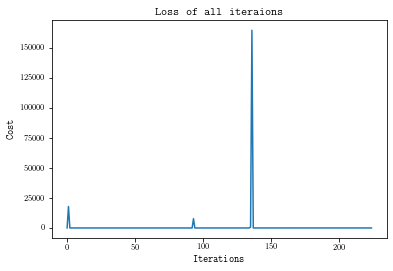

<Figure size 720x360 with 0 Axes>

In [7]:
plt.plot(range(225), model.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.title('Loss of all iteraions')
fig = plt.figure(figsize=(10,5))
fig.savefig('Loss of all iteraions.jpg.', bbox_inches='tight', dpi=150)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1,) and (321,)

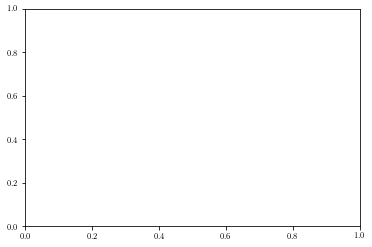

In [81]:
plt.plot((len(model.eval_['cost']),), model.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

In [ ]:
len(model.eval_['cost'])